In [213]:
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
initial_conc = range(700,800,25)
serca_f = range(3.5,7,0.5)
fnames=[]

In [192]:
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [268]:
def write_mdl(file_name,ic,sf,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = 1000e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er=e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f=                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm=3 //multiply all serca parameters

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */
    //k_PMCA_0_1 = 0
    //k_PMCA_0_leak = 0


    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f)   	
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = "brute750_2"

        output_folder = outputLoc & "ppf/" & fname & "/" & f_mult & "/" & init_er_conc & "/s_" & my_seed

    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21 = 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    
    ftext=ftext.replace('ca_conc_presynaptic_er=', 'ca_conc_presynaptic_er='+str(ic))
    ftext=ftext.replace('f=','f='+str(sf))
    for i,p in enumerate(['x1','x1a','x2','y1','y1a','y2']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)

    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)

    

In [269]:
initial_conc = range(350,650,50)
serca_f = range(2,7)

#obtaining SERCA equilibrium data
sdata={}
for sf in serca_f:
    sdata[sf]={}
    for ic in initial_conc[0:6]:
        #print ic,sf
        data_file='/data/kabir/output/ppf/brute750/'+str(sf)+'/'+str(ic)+'/s_00001/dat/serca_mol.dat'
        sdata[sf][ic]=np.loadtxt(data_file)[-1][1:7]
        #print np.sum(sdata[sf][ic])

In [270]:
initial_conc = range(700,800,4)
serca_f = [3.5,4,4.5,5.0,5.5,6,6.5,7]
fnames=[]

for ic in initial_conc:
    for sf in serca_f:
        fname="/home/kabir/Project/tripartiteSynapse/brute750_2/RSnostim_"+str(sf)+"_"+str(ic)+".mdl"
        fnames.append(fname)
        write_mdl(fname,ic,sf,[line(sf,*fit[i]) for i in range(0,6)])

In [276]:
fnames=[fname.replace('Project/','') for fname in fnames]
bashtext="parallel mcell33 ::: "+' '.join(fnames[0:25])
with open('/home/kabir/Project/tripartiteSynapse/brute750_2/run.sh','w') as f:
    f.write(bashtext)
#["parallel","mcell",":::"]+fnames
#p=subprocess.call(["parallel","mcell",":::","/home/kabir/Project/tripartiteSynapse/ryr_750/RSnostim.mdl"])

In [271]:
len(fnames)

32

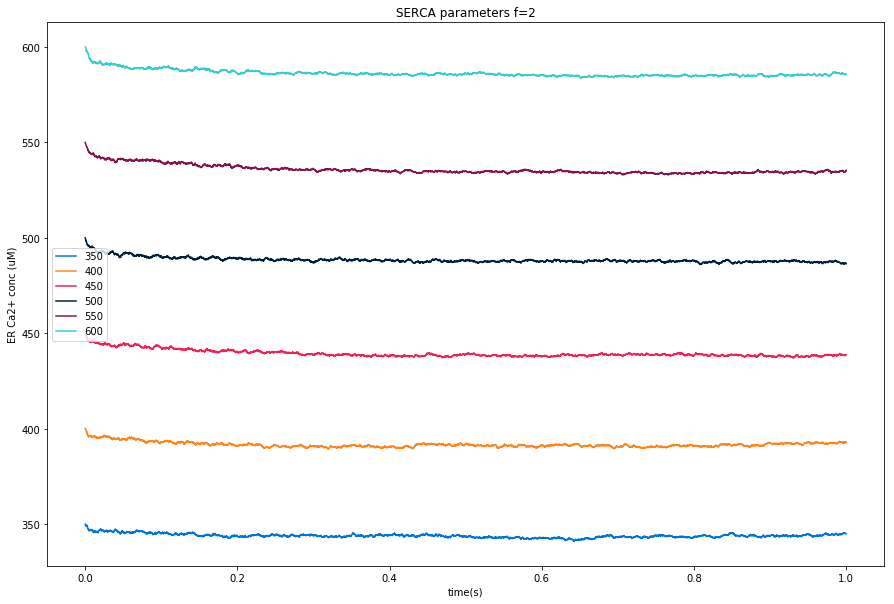

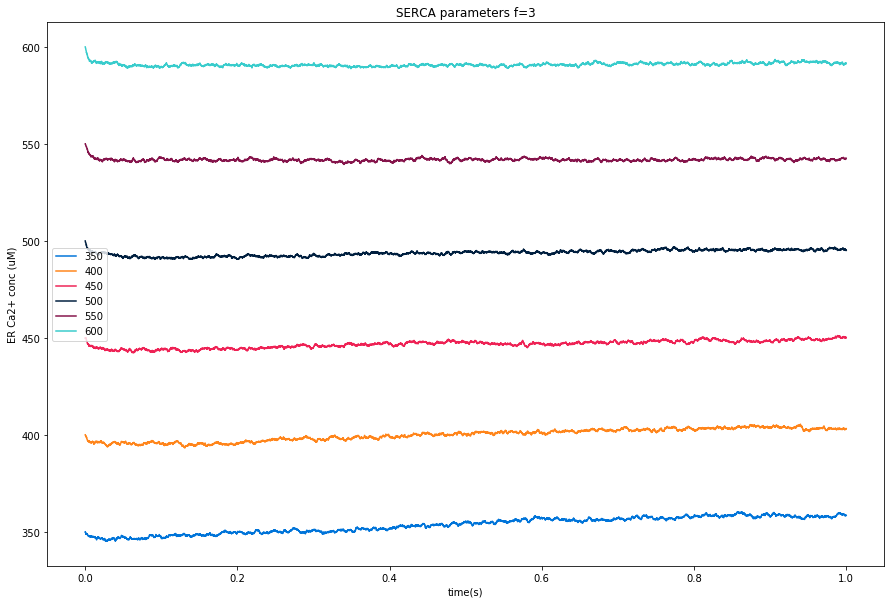

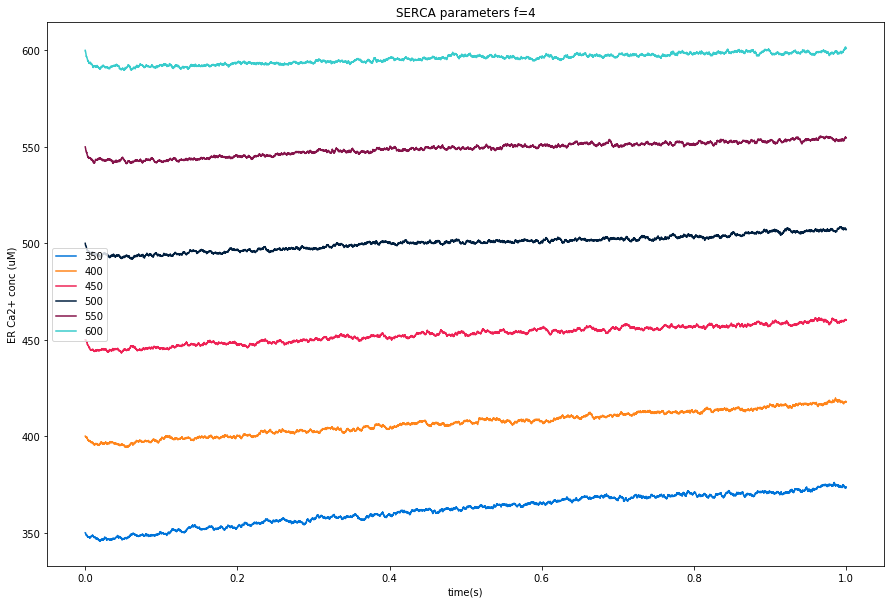

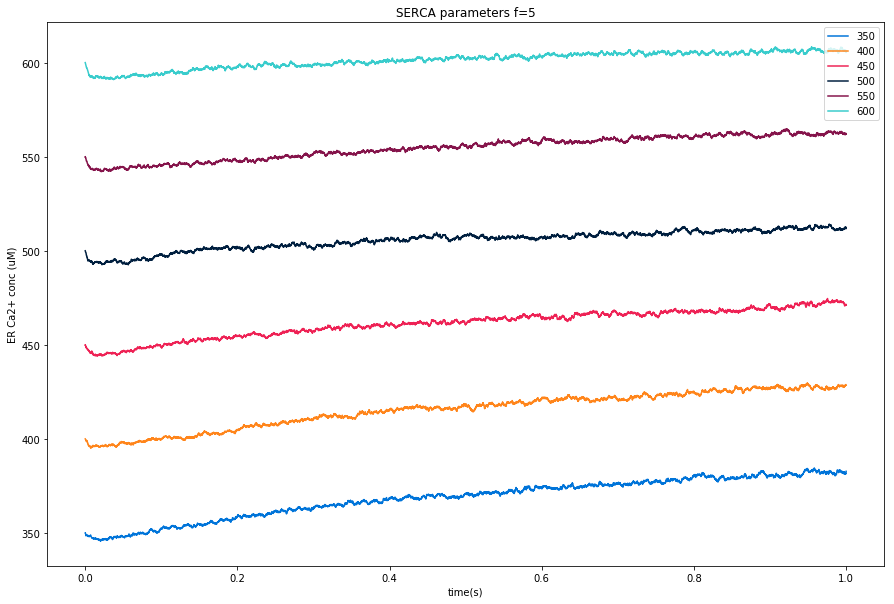

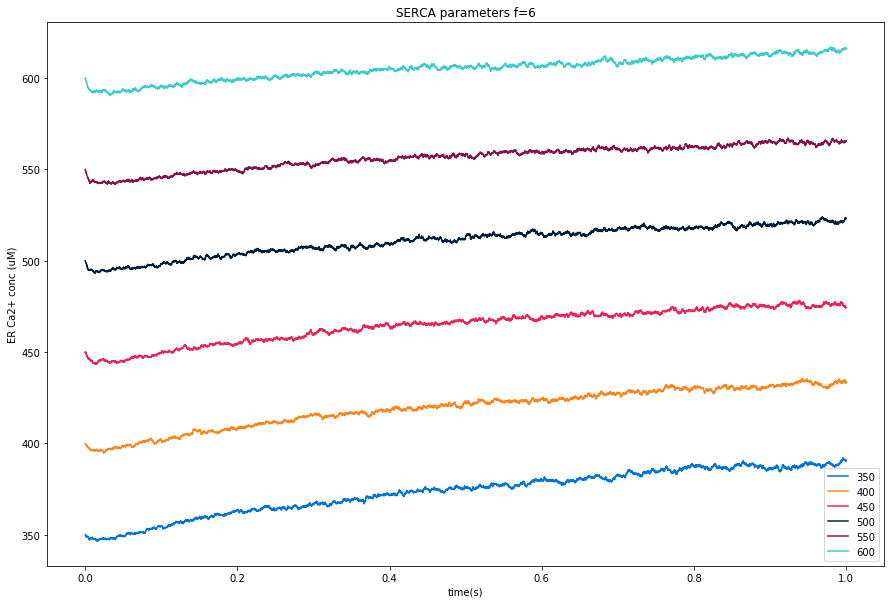

In [71]:
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

data={}
sf=5

for sf in serca_f:
    plt.figure(figsize=(15,10))
    for i,ic in enumerate(initial_conc[0:6]):
        data_file='/data/kabir/output/ppf/brute750/'+str(sf)+'/'+str(ic)+'/s_00001/dat/ca.dat'
        #print data_file
        data[ic]=np.loadtxt(data_file)
        data[ic].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar
        plt.plot(data[ic].T[0],data[ic].T[3],color=color[i],label=str(ic))

    plt.xlabel('time(s)')
    plt.ylabel('ER Ca2+ conc (uM)')

    plt.legend()
    plt.title('SERCA parameters f='+str(sf))

    #plt.savefig('/home/kabir/Project/plots/serca_f'+str(sf)+'.png')

In [102]:
def calb_pmca_plot(dat_loc):
    pmca_data = np.loadtxt(dat_loc+'pmca&leak_ca_flux.dat')
    calb_data = np.loadtxt(dat_loc+'calbindin_mol.dat')
    
    color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
    
    plt.figure(figsize=(15,6))

    #plot PMCA flux
    plt.plot(pmca_data.T[0],pmca_data.T[2]-pmca_data.T[1],color=color[i],label="PMCA Flux IN(leak)-OUT")

    #plot calcium released by calbindin (initial-final bound calbindin)
    calb_tot_bnd=calb_data.T[2]+calb_data.T[4]+2*(calb_data.T[3]+calb_data.T[5]+calb_data.T[7])+3*(calb_data.T[6]+calb_data.T[8])+4*calb_data.T[9]
    calb_rel=calb_tot_bnd[0]-calb_tot_bnd
    plt.plot(pmca_data.T[0],calb_rel,label="Calbindin released calcium")
    plt.legend()
    #plt.savefig('/home/kabir/Project/plots/calb_pmca.png')

In [104]:
sf=3
ic=600
#calb_pmca_plot('/data/kabir/output/ppf/brute750/'+str(sf)+'/'+str(ic)+'/s_00001/dat/')

In [105]:
#calb_pmca_plot('/data/kabir/output/ppf/old_stuff/old_RSnostim_250RSnostim_250_noleak/s_00001/dat/')

In [119]:
def serca_mol_plot(dat_loc):
    serca_mol= np.loadtxt(dat_loc+'/serca_mol.dat')
    plt.figure(figsize=(15,6))
    for i,lb in enumerate(['X1','X1a','X2','Y1','Y1a','Y2']):
        plt.plot(serca_mol.T[0],serca_mol.T[i+1],label=lb)

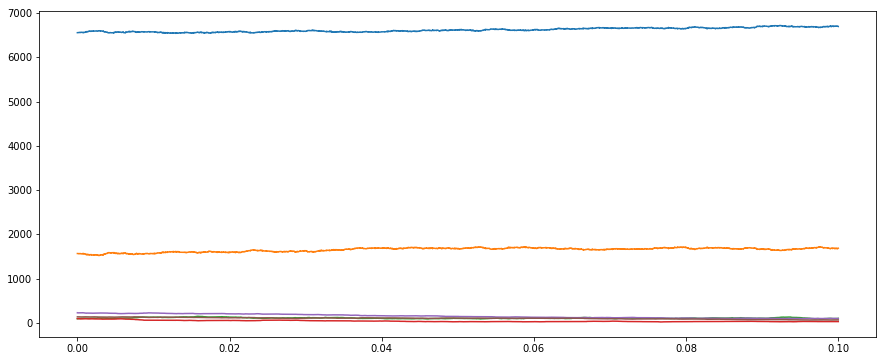

In [120]:
serca_mol_plot('/data/kabir/output/ppf/old_stuff/old_RSnostim_250RSnostim_250_noleak/s_00001/dat/')

In [118]:
data_file='/data/kabir/output/ppf/brute750/'+str(sf)+'/'+str(ic)+'/s_00001/dat/ca.dat'
data[ic]=np.loadtxt(data_file)
data[ic].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar


{2: {350: array([5766., 2412.,  235.,   70.,  133.,   62.]),
  400: array([5729., 2412.,  305.,   70.,  114.,   48.]),
  450: array([5785., 2413.,  258.,   78.,  106.,   38.]),
  500: array([5827., 2364.,  285.,   85.,   95.,   22.]),
  550: array([5812., 2397.,  258.,   83.,   93.,   35.]),
  600: array([5764., 2415.,  322.,   74.,   90.,   13.])},
 3: {350: array([5280., 2514.,  370.,  166.,  249.,   99.]),
  400: array([5333., 2481.,  386.,  169.,  219.,   90.]),
  450: array([5348., 2484.,  395.,  155.,  225.,   71.]),
  500: array([5410., 2499.,  365.,  171.,  178.,   55.]),
  550: array([5394., 2477.,  417.,  169.,  168.,   53.]),
  600: array([5341., 2512.,  416.,  191.,  170.,   48.])},
 4: {350: array([5151., 2249.,  457.,  255.,  406.,  160.]),
  400: array([5178., 2267.,  471.,  254.,  369.,  139.]),
  450: array([5123., 2356.,  465.,  274.,  343.,  117.]),
  500: array([5242., 2282.,  462.,  277.,  317.,   98.]),
  550: array([5146., 2366.,  499.,  293.,  278.,   96.]),
  6

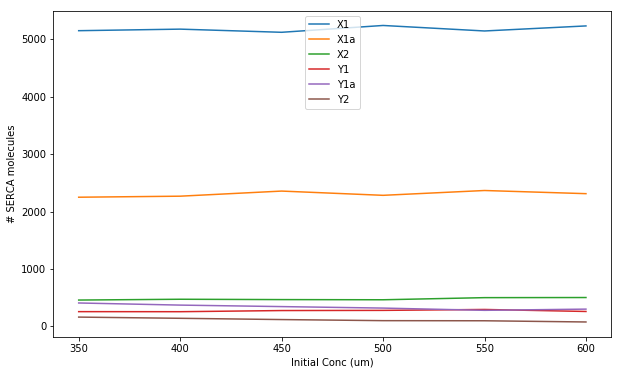

In [140]:
#for sf in serca_f:
sf=4
plt.figure(figsize=(10,6))
for i,lb in enumerate(['X1','X1a','X2','Y1','Y1a','Y2']):
    state_series=[]
    for ic in initial_conc[0:6]:
        state_series.append(sdata[sf][ic][i])
    plt.plot(initial_conc[0:6],state_series,label=lb)

plt.xlabel('Initial Conc (um)')
plt.ylabel('# SERCA molecules')
plt.legend()

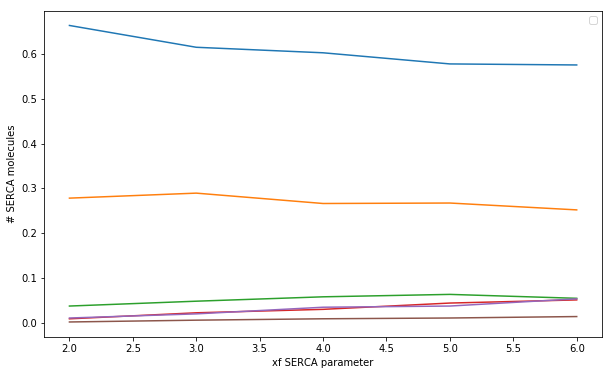

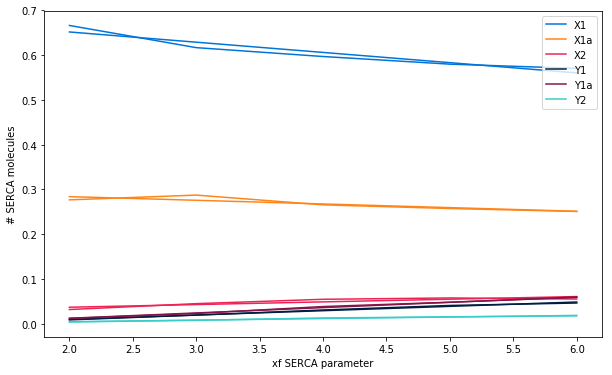

In [241]:
initial_conc=range(350,650,50)
serca_f=range(2,7)

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

plt.figure(figsize=(10,6))
for i,lb in enumerate(['X1','X1a','X2','Y1','Y1a','Y2']):
    plt.plot(serca_f,[sdata[sf][600][i]/8678.0 for sf in serca_f])
#plt.ylim((0,1000))
plt.xlabel('xf SERCA parameter')
plt.ylabel('# SERCA molecules')
plt.legend()

plt.figure(figsize=(10,6))
fit=[]
for i,lb in enumerate(['X1','X1a','X2','Y1','Y1a','Y2']):
    ydata=[np.average([sdata[sf][ic][i]/8678.0 for ic in initial_conc[0:6]]) for sf in serca_f]
    xdata=serca_f
    plt.plot(xdata,ydata, color=color[i],label=lb)
    popt,pcov=curve_fit(line,xdata,ydata)
    fit.append(popt)
    xdata = np.linspace(2, 6, 50)
    plt.plot(xdata, line(xdata, *fit[i]), color=color[i])

#plt.ylim((0,1000))
plt.xlabel('xf SERCA parameter')
plt.ylabel('# SERCA molecules')
plt.legend()

In [222]:
def line(x,A,B):
    return A*x+B

In [242]:
fit

[array([-0.02284321,  0.697292  ]),
 array([-0.00818161,  0.30038027]),
 array([0.00596336, 0.02517093]),
 array([ 0.00967965, -0.00933011]),
 array([ 0.01187101, -0.01124683]),
 array([ 0.00351079, -0.00226627])]

In [247]:
np.sum([line(3,*fit[i]) for i in range(0,6)])

0.9999999999641

In [239]:
np.sum(sdata[3][350])

8678.0